# Sobol index calculated over 10 years (2008-2018)

# Import module


In [36]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mordor_sd_assim import mordor_sd
import datetime
import litres
from save_tools import *
import  pickle
import properscoring as ps



#  Arrays definitions

In [37]:

""" Arrays sizes definition
npmt : number of parameters
ncond: number of initial conditions ? to verify
nres : number of results colomns in the final structure
tmax : number of dates pissibly simulated by Mordor
"""
npmt  = 100   
ncond = 72
nres  = 74 #230 
tmax  = 2000

#  Function to read file parameters

In [38]:

def res2pmt(data_file) :
    """Reader of parameters file for the Mordor model
    Input:
    -------
    - data_file: file name to read
    Output:
    -------
    - pmtdict: Dictionnary with parameters
      parameters names can be retrieved with 'names' key
    variables:
    -------
    pmt     : parameters arrays filled by the litres Fortran code
    pmtdict : dictionnay with all parameters
    name    : names of each parameters
    """
    pmt = np.zeros(npmt)
    
    litres.litres(nomfic=data_file, pmtmor=pmt)
    
    name = ["mod_neige","mod_deriv","mod_lac","mod_etp","mod_glace","mod_out","sbv","pdt","dh","fglace",
           "flac","xlat","z50","ztair","lonR","nstock","cp","cetp","csbv","gtz","gpz","etp1","etp2",
           "kmin","umax","lmax","zmax","evl","kr","lkn","evn","cel","dif","qcel","qdif","kf","kfp","efp",
           "eft","lts","gm","kg","kgp","efg","jg","ptjp1","raym","qext","zs1","fs1","fgi1","fgf1","zs2",
           "fs2","fgi2","fgf2","zs3","fs3","fgi3","fgf3","zs4","fs4","fgi4","fgf4","zs5","fs5","fgi5","fgf5",
           "zs6","fs6","fgi6","fgf6","zs7","fs7","fgi7","fgf7","zs8","fs8","fgi8","fgf8","zs9","fs9","fgi9",
           "fgf9","zs10","fs10","fgi10","fgf10","nsbv","qres","lqs","x92","x93","x94","x95","x96","x97","x98","x99","x100"]
    
    pmtdict={}
    
    for i in range(npmt):
        pmtdict[name[i]] = pmt[i]
    pmtdict['names'] = name
    return pmtdict

# Mordor calling function

In [39]:
def Calcul_MordorSD(Date, QS, NS, PS, TS, pmtdictn, cond=[np.nan]):
    """Driver for MORDOR simulation.
    Inputs:
    -------
    - Date: date objet
    - QS: observed flow rate, for comparison with the simulation
    - PS: precipitation (forcing)
    - TS: surface temperature (forcing)
    - pmtdict: model parameters, read from a parameter files of the type Param_Durance@Clapiere.res with function res2pmt
    Outputs:
    --------
    - dictionary with ("Date","Qobs","PS","T","Qam","rbase","rvers","rsurf", "S", "fneige",
      "U","L","Z","N","ep","er","Qmod","lg","agl")
      products names can be retrieved with the 'names' key
    variables:
    --------
    pmt  : parameters arrays filled by using the pmtdict dictionnary
    npdt : number of date to simulate
    JJ   : julian days computed from Date
    don  : an array with JJ,QS,PS,TS as input of the Mordor model
    res0 : output array
    init : integer (0 or 1) to initialise the Model set to 1
    cond         : array as input of the Mordor model, initial conditions ? to ask to EDF
    don_f, pmt_f, cond_f and res0_f: as respectively the arrays don, pmt, cond and res0
                   converted in arrays using Fortran-like index order
    RES          : dictionnary containing all products results
    RES['names'] : names on each product
  
    """

    pmt = np.zeros(npmt)
    for i_n in range(npmt):
        pmt[i_n] = pmtdict[pmtdict['names'][i_n]]
    
    npdt=len(Date)
    
    # julian days computation
    JJ = list()
    for id in Date: JJ.append(id.timetuple().tm_yday)
    
    don = np.zeros((tmax, 4))
    don[0:npdt,0] = np.asarray(JJ)
    don[0:npdt,1] = np.asarray(QS)
    don[0:npdt,2] = np.asarray(PS)
    don[0:npdt,3] = np.asarray(TS)

    res0 = np.zeros((tmax, nres))
    
    if cond[0]!=cond[0]: # no initialization
        init = 0
        cond = np.zeros(ncond)+1
    else: # initialization given
        init = 0

    cond[0] = npdt
    
    # creation of arrays using Fortran-like index order
    don_f  = np.array(don, dtype=np.float, order='F')
    pmt_f  = np.array(pmt, dtype=np.float, order='F')
    cond_f = np.array(cond, dtype=np.float, order='F')
    res0_f = np.array(res0, dtype=np.float, order='F')
    
    mordor_sd(don_f, pmt_f, cond_f, res0_f, init)
    

    # outputs data storage
    RES = {}
       # list of the names of each column in the outputs (in the same order as in the fortran)
    list_res   = ["Q", "fneige", "S", "N",  \
        "U_1", "U_2", "U_3", "U_4", "U_5", "U_6", "U_7", "U_8", "U_9", "U_10", \
        "L_1", "L_2", "L_3", "L_4", "L_5", "L_6", "L_7", "L_8", "L_9", "L_10", \
        "Z_1", "Z_2", "Z_3", "Z_4", "Z_5", "Z_6", "Z_7", "Z_8", "Z_9", "Z_10", \
        "S_1", "S_2", "S_3", "S_4", "S_5", "S_6", "S_7", "S_8", "S_9", "S_10", \
        "sns_1", "sns_2", "sns_3", "sns_4", "sns_5", "sns_6", "sns_7", "sns_8", "sns_9", "sns_10", \
        "snl_1", "snl_2", "snl_3", "snl_4", "snl_5", "snl_6", "snl_7", "snl_8", "snl_9", "snl_10", \
        "tst_1", "tst_2", "tst_3", "tst_4", "tst_5", "tst_6", "tst_7", "tst_8", "tst_9", "tst_10"]

    RES['names']  = list_res
    
    RES['Date']   = Date[0:npdt]
    RES['Qobs']   = np.asarray(QS[0:npdt])
    RES['Sobs']   = np.asarray(NS[0:npdt])
    RES['PS']     = np.asarray(PS[0:npdt])
    RES['T']      = np.asarray(TS[0:npdt])
    
    # filling the RES dictionary with each Mordor output
    for i_r in range(nres):
        RES[list_res[i_r]] = res0_f[0:npdt,i_r]


    return RES


# Function to create cond array (initial condition)

In [40]:
def make_cond_init(RES, npdt):
    """
    Function to create cond array (initial condition)
    Initial condition is made from last values (last date of simulation)
    of Mordor outputs
    -----
    Input:
    - RES: dictionary containing outputs from Mordor
    - nptd: nb of dates that will be simulated (can be 0 because
            this element is corrected juste before Mordor calling)
    Output:
    - cond: array containing Mordor initialization
    """
    
    # liste of each parameter need to be given in cond array
    list_cond_init = ["npdt", "N",\
         "U_1", "L_1", "Z_1", "S_1", "sns_1", "snl_1", "tst_1",\
         "U_2", "L_2", "Z_2", "S_2", "sns_2", "snl_2", "tst_2",\
         "U_3", "L_3", "Z_3", "S_3", "sns_3", "snl_3", "tst_3",\
         "U_4", "L_4", "Z_4", "S_4", "sns_4", "snl_4", "tst_4",\
         "U_5", "L_5", "Z_5", "S_5", "sns_5", "snl_5", "tst_5",\
         "U_6", "L_6", "Z_6", "S_6", "sns_6", "snl_6", "tst_6",\
         "U_7", "L_7", "Z_7", "S_7", "sns_7", "snl_7", "tst_7",\
         "U_8", "L_8", "Z_8", "S_8", "sns_8", "snl_8", "tst_8",\
         "U_9", "L_9", "Z_9", "S_9", "sns_9", "snl_9", "tst_9",\
         "U_10", "L_10", "Z_10", "S_10", "sns_10", "snl_10", "tst_10"]
    

    cond = np.zeros(ncond)
    # npdt corresponds to nb of dates in Mordor simulations,
    # it will be replaced just before Mordor calling
    cond[0] = npdt

    # cond filling
    for i_c in range(ncond):
        # skip first element (already stored)
        if i_c==0: continue
        # parameters are retrieved from RES dictionary (output of Mordor)
        # last value (last date of simulation) of each parameter is taken
        cond[i_c] = RES[list_cond_init[i_c]][-1]

    return cond


# Sobol indice

In [42]:
def make_perturb(x):
    """
    """
    list_to_perturb = ["S_1","S_2","S_3","S_4","S_5","S_6","S_7",\
               "S_8","S_9","S_10"]
    x_p = np.zeros(len(x))
    pourcent = 100.
    
    for ip in range(len(x)):
        if list_cond_init[ip] in  list_to_perturb: # we perturbe
            x_p[ip] = x[ip] * (1. + np.random.uniform(-pourcent/100., pourcent/100.))
        else: # no perturbation
            x_p[ip] = x[ip] 
   
    return x_p

In [43]:

"""
Initialization interface
- file_analyse : file containing initialisation
- d_ini_known  : beginning forcing date (format: YYYY-MM-DD)
- d_end_known  : end forcing date

Forecast interface
- d_end_fcst   : end unknown date
- d_first_old  : date of the old experiment
- n_old        : number of simulations
- year_step    : time step between each simulation (in year)

- data         : QPT values file name
- file_param   : parameters file name

Outputs save
- d_ini_save   : fisrt date to save
- save_file_n  : output fine name
"""

###### Initialisation

#d_ini_known   = "2014-09-01"
#d_end_known   = "2017-03-31"


###### forecast
#d_end_fcst    = "2017-08-31"
for i_an in range(10):
    annee_previ = 2008 + i_an
    annee_deb_hiver =  2008 + i_an -3

    d_ini_known     = str( annee_deb_hiver ) + "-09-01"
    d_end_known   = str( annee_previ ) + "-03-31"
    d_end_fcst    = str( annee_previ ) + "-08-31"

    Ne = 50
    save_file_n = "fichier_sauv_pert_100"
    ######
    data       = "QPThisto_J_isere@bvi_coche_ponserand_valid.txt"
    data2      = "SWE_NRC_NDAout.txt"
    file_param = "isere_FINAL_J_SIM.res"


# parameters reading
    pmtdict = res2pmt(file_param)

# output mode of Mordor (specific to the wrapper)
    pmtdict["mod_out"] = 3

#####################################################################
#####################################################################

    d_fin = datetime.datetime.strptime(d_end_fcst, '%Y-%m-%d')
    d_ikn = datetime.datetime.strptime(d_ini_known, '%Y-%m-%d')
    d_ekn = datetime.datetime.strptime(d_end_known, '%Y-%m-%d')
    
###
    Qobs   = list()
    PSo    = list()
    TSo    = list()
    date_l = list()

#fmt   = '%d/%m/%Y' #'01/01/1948'

# observations file reading
    QPT = open(data)
    il=0
    i_dt = 0
    for iline in QPT:
        tmp_line = iline.split()
        il += 1
        if il==1: continue
        dt = datetime.datetime.strptime(tmp_line[0][1:11], '%d/%m/%Y')
        if (dt > d_fin): continue
        i_dt += 1
    # on note les indices de debut et fin de la periode donnue
        if (dt == d_ikn): index_ikn = i_dt -1
        if (dt == d_ekn): index_ekn = i_dt -1
        date_l.append(dt)
        Qobs.append(float(tmp_line[1]))
        PSo.append(float(tmp_line[2]))
        TSo.append(float(tmp_line[3]))

    QPT.close()

###
    Sobs   = list()
    date_l2 = list()

#fmt   = '%d/%m/%Y' #'01/01/1948'

# observations file reading, NRC
    QPT2 = open(data2)
    il=0
    i_dt = 0
    for iline in QPT2:
        tmp_line = iline.split()
        il += 1
        if il==1: continue
        dt = datetime.datetime.strptime(tmp_line[0][1:11], '%d/%m/%Y')
    # If date before end init then: continue
        if (dt > d_fin): continue
        i_dt += 1
    # we note the beginning and end of the period given
        if (dt == d_ikn): index_ikn2 = i_dt -1
        if (dt == d_ekn): index_ekn2 = i_dt -1
        date_l2.append(dt)
        Sobs.append(float(tmp_line[1]))

    QPT2.close()
    
### winter
    date_hiver = date_l[index_ikn:index_ekn+1]
    Qobs_hiver = Qobs[index_ikn:index_ekn+1]
    Sobs_hiver = Sobs[index_ikn2:index_ekn2+1]
    PS_hiver   = PSo[index_ikn:index_ekn+1]
    TS_hiver   = TSo[index_ikn:index_ekn+1]

    print("Run hiver")
    RES_hiver = Calcul_MordorSD(date_hiver, Qobs_hiver, Sobs_hiver, PS_hiver, TS_hiver, pmtdict)


### summer
    date_ete = date_l[index_ekn+1:]
    Qobs_ete = Qobs[index_ekn+1:]
    Sobs_ete = Sobs[index_ekn2+1:]
    PS_ete   = PSo[index_ekn+1:]
    TS_ete   = TSo[index_ekn+1:]

    npdt = len(date_ete)
    cond_ete = make_cond_init(RES_hiver, npdt)
    
    
   #calcul of matrices A
    
    Amat = np.zeros((len(cond_ete), Ne))
    for iN in range(Ne):
        Amat[:, iN] = make_perturb(cond_ete)
        
    print("Run A")
    A_res = []
    for iN in range(Ne):
    #print("A: "+str(iN))
        res = Calcul_MordorSD(date_ete, Qobs_ete, Sobs_ete, PS_ete, TS_ete, pmtdict, cond=Amat[:, iN])
        A_res.append(res)
        
        
    # calcul of matrice B
    Bmat = np.zeros((len(cond_ete), Ne))
    for iN in range(Ne):
        Bmat[:, iN] = make_perturb(cond_ete)
    print("Run B")
    B_res = []
    for iN in range(Ne):
    #print("B: "+str(iN))
        res = Calcul_MordorSD(date_ete, Qobs_ete, Sobs_ete, PS_ete, TS_ete, pmtdict, cond=Bmat[:, iN])
        B_res.append(res)
        
        # calcul of matrices Ci
    Cmat = np.zeros((len(cond_ete), len(cond_ete), Ne))
    for iK in range(len(cond_ete)):
        Cmat[iK, :, :]  = Amat[:, :]
        Cmat[iK, iK, :] = Bmat[iK, :]
        
    print("Run C")
    Ci_res = []
    for iK in range(len(cond_ete)):
    #print("C: K "+str(iK))
        Ires = []
        for iN in range(Ne):
        
            res = Calcul_MordorSD(date_ete, Qobs_ete, Sobs_ete, PS_ete, TS_ete, pmtdict, cond=Cmat[iK, :, iN])
            Ires.append(res)
        Ci_res.append(Ires)
        
    list_cond_init = ["npdt", "N", \
        "U_1", "L_1", "Z_1", "S_1", "sns_1", "snl_1", "tst_1", \
        "U_2", "L_2", "Z_2", "S_2", "sns_2", "snl_2", "tst_2", \
        "U_3", "L_3", "Z_3", "S_3", "sns_3", "snl_3", "tst_3", \
        "U_4", "L_4", "Z_4", "S_4", "sns_4", "snl_4", "tst_4", \
        "U_5", "L_5", "Z_5", "S_5", "sns_5", "snl_5", "tst_5", \
        "U_6", "L_6", "Z_6", "S_6", "sns_6", "snl_6", "tst_6", \
        "U_7", "L_7", "Z_7", "S_7", "sns_7", "snl_7", "tst_7", \
        "U_8", "L_8", "Z_8", "S_8", "sns_8", "snl_8", "tst_8", \
        "U_9", "L_9", "Z_9", "S_9", "sns_9", "snl_9", "tst_9", \
        "U_10", "L_10", "Z_10", "S_10", "sns_10", "snl_10", "tst_10"]   

    list_to_plot = ["S_1", "S_2", "S_3", "S_4", "S_5", "S_6", "S_7", "S_8", "S_9", "S_10"] #,
    
    estim = "Q"

    var_i  = np.zeros(len(cond_ete))
    vart_i = np.zeros(len(cond_ete))
    mean_i = np.zeros(len(cond_ete))
    for iK in range(len(cond_ete)):
        for iN in range(Ne):
            var_i[iK]  += abs(np.sum(B_res[iN][estim][:])*( np.sum(Ci_res[iK][iN][estim][:]) - np.sum(A_res[iN][estim][:]) ) / Ne)
            vart_i[iK] += abs(np.sum(A_res[iN][estim][:])*( np.sum(A_res[iN][estim][:]) - np.sum(Ci_res[iK][iN][estim][:]) ) / Ne)
            mean_i[iK] += np.sum(A_res[iN][estim][:]) / Ne
        pourc = 100. * (np.sqrt(var_i) / mean_i)
    print pourc
        
        # Saving to external files
    save_file_ens = save_file_n + "_" + str(annee_previ) + ".nc"

    print('Saving outputs...')

    # preparation of the tables to be recorded


    data_out = {}

    data_out['var']      = var_i
    data_out['mean']      = mean_i


    # stored the dictionary in NetCdf file


    rec_tabs(data_out, save_file_ens)
        


Run hiver
Run A
Run B
Run C


/home/farouki/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in divide


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.97013116  0.          0.          0.          0.
  0.          0.         11.97371297  0.          0.          0.
  0.          0.          0.         22.51582462  0.          0.
  0.          0.          0.          0.         28.72769989  0.
  0.          0.          0.          0.          0.         29.92595967
  0.          0.          0.          0.          0.          0.
 25.71154444  0.          0.          0.          0.          0.
  0.         15.22707709  0.          0.          0.          0.
  0.          0.          7.05607631  0.          0.          0.        ]
Saving outputs...
Run hiver
Run A
Run B
Run C
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0

# Plot

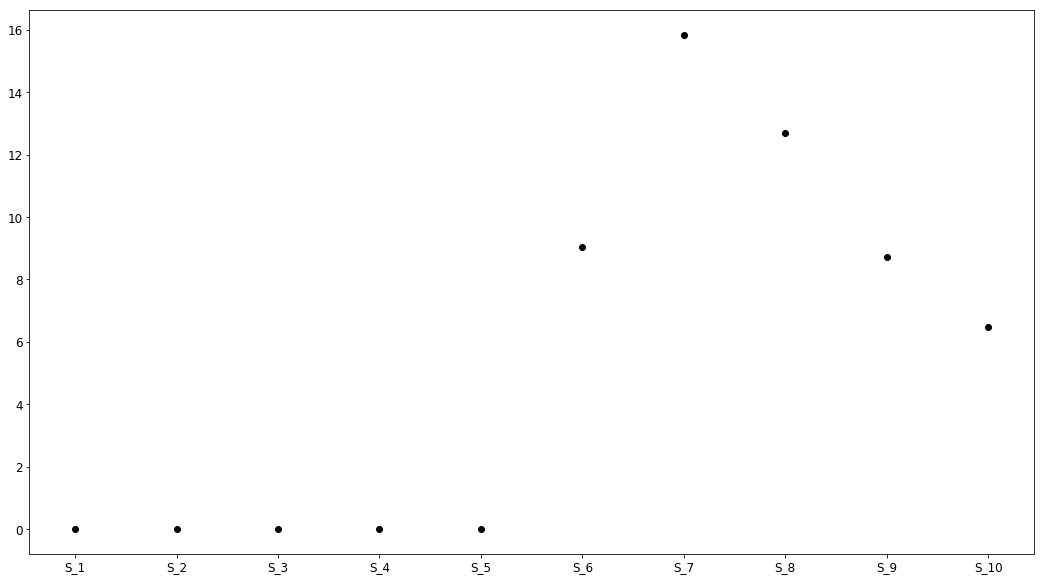

In [28]:
matplotlib.rcParams['font.size'] = 7.
# matplotlib.rcParams['figure.titlesize'] = 12.
# matplotlib.rcParams['axes.labelsize'] = 12.
matplotlib.rcParams['xtick.labelsize'] = 12.
matplotlib.rcParams['ytick.labelsize'] = 12.
fig = plt.figure(1, figsize=(18, 10))

for i_tp in list_to_plot:
    ind = np.nonzero(i_tp == np.asarray(list_cond_init))[0]
    # trace indice Sobol premier ordre
    #plt.plot([i_tp], var_i[ind]/sum(vart_i), 'ko')
    # trace indice Sobol ordre total
   # plt.plot([i_tp], vart_i[ind]/sum(vart_i), 'r.')

#cumulative percentage
    plt.plot([i_tp],  100. * (np.sqrt(var_i[ind]) / mean_i[ind]), 'ko')




plt.show()